In [13]:
from scipy import ndimage as ndi
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import img_as_float
from PIL import Image
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.affinity import scale

import laspy
from sklearn.cluster import DBSCAN
import numpy
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import coord_f
import folium
import visualize
import db_settings
import geopandas
import pandas
import create_new_las
from datetime import datetime
from pathlib import Path
import warnings

import csv
def save(id,tree_id, gattung_id, save_path_id, algo_id):   
    req = """ ("""+str(id) + """, """+str(tree_id)+""", """+str(gattung_id)+""", """+str(save_path_id)+""", """+str(algo_id)+"""),"""
    #x, y, z = numpy.array(points).transpose()
    #las = create_new_las.build_las(las_scale_factor, x,y,z, header=header)     
    return req #, las

In [2]:
file = "lidar-files/4categorized/Wesel/3dm_32_326_5728_1_nw.las"
save_path_id = 100
save_doubles_id = 101
classes_to_cluster = [5]
city_code=3
warnings.filterwarnings("ignore")
print("starting with ", file)
start_time = datetime.now()
print("time: ", start_time)
#prepare saving:
print("connecting to database:")
db =db_settings.db(autocommit=False)
print("requseting database")

db_file_name = str(file).split('/')[-1].split('\\')[-1].split('.')[0]
print(db_file_name)
req = """SELECT ID, NUMBER_OF_TREES FROM lidar_proj.LIDAR_FILES WHERE FILE_NAME = \'"""+db_file_name+"""\'"""
print(req)
lidar_file_number = db.export_to_pandas(req)
print("lidar file id:", lidar_file_number['ID'][0], " NUMBER_OF_TREES: ", lidar_file_number['NUMBER_OF_TREES'][0])
req ="""SELECT * FROM lidar_proj.trees WHERE city_ID=""" + str(city_code) +""" and LIDAR_FILE_ID="""+str(lidar_file_number['ID'].values[0])+""" ORDER BY id"""
print(req)
trees =db.export_to_pandas(req)
print (trees)

starting with  lidar-files/4categorized/Wesel/3dm_32_326_5728_1_nw.las
time:  2022-07-13 14:26:03.647825
connecting to database:
requseting database
3dm_32_326_5728_1_nw
SELECT ID, NUMBER_OF_TREES FROM lidar_proj.LIDAR_FILES WHERE FILE_NAME = '3dm_32_326_5728_1_nw'
lidar file id: 813  NUMBER_OF_TREES:  289
SELECT * FROM lidar_proj.trees WHERE city_ID=3 and LIDAR_FILE_ID=813 ORDER BY id
         ID              X             Y  CITY_ID  ID_GATTUNG  LIDAR_FILE_ID
0     97232  326926.011555  5.728650e+06        3         103            813
1    102329  326173.919721  5.728051e+06        3          10            813
2    102330  326201.171654  5.728053e+06        3          10            813
3    102344  326160.662544  5.728092e+06        3         115            813
4    102347  326176.936560  5.728070e+06        3          90            813
..      ...            ...           ...      ...         ...            ...
284  107805  326203.306913  5.728093e+06        3         116           

In [3]:
print("complete")

print("prepare saving:")

max_id = db.export_to_pandas("""SELECT max(id) FROM lidar_proj.cluster""")['MAX(CLUSTER.ID)'][0]
if numpy.isnan(max_id):
    max_id = 0
else:
    max_id=int(max_id)
print("starting with id=", max_id)

save_to = db.export_to_pandas("""SELECT save_path FROM lidar_proj.cluster_path where id="""+ str(save_path_id))['SAVE_PATH'][0]

save_to = os.path.join(os.getcwd(), "clusters", save_to)
print("savepath: ", save_to)
save_doubles_to = db.export_to_pandas("""SELECT save_path FROM lidar_proj.cluster_path where id="""+ str(save_doubles_id))['SAVE_PATH'][0]
print(save_to)
save_doubles_to = os.path.join(os.getcwd(),"clusters", save_doubles_to)
print("savepath doubles: ", save_doubles_to)
if not os.path.exists(save_doubles_to):
    Path.mkdir(Path(save_doubles_to),parents=True, exist_ok=True)
if not os.path.exists(save_to):
    Path.mkdir(Path(save_to), parents=True, exist_ok=True)
csv_save_path = str(save_to)+'/' + str(file).split('.')[0].split('/')[-1].split('\\')[-1] +'_clusters.csv'
csv_save_path_doubles = str(save_doubles_to)+'/' + str(file).split('.')[0].split('/')[-1].split('\\')[-1]  +'_clusters_doubles.csv'
print("csv saved to: ", csv_save_path, " ", csv_save_path_doubles)



print("read las file...")

algo_id = 1 #references dbsvan
las = laspy.read(file)
las_points_x = numpy.array(las.points['x']) 
las_points_y = numpy.array(las.points['y'])
x_max, x_min, y_max, y_min = las_points_x.max(),  las_points_x.min(), las_points_y.max(),  las_points_y.min()
x_range = x_max - x_min
y_range = y_max - y_min

length = len(las.points['x'])    

print("selecting points to cluster by classification")
points_to_cluster = numpy.array([[las.points['x'][i], las.points['y'][i], las.points['z'][i]] for i in tqdm(range(length)) if (las.points['classification'][i] in classes_to_cluster)]) 
print("selecting idices of this poibts")

#indices_of_cluster_points = numpy.array([i for i in tqdm(range(length)) if (las.points['classification'][i] in classes_to_cluster)]) 
points_to_cluster2d = points_to_cluster[:,:2]
print("clustering")
cluster = DBSCAN(eps=0.6, min_samples=5).fit(points_to_cluster2d)  # parameters according to https://www.degruyter.com/document/doi/10.1515/geo-2020-0266/html?lang=de
labels = cluster.labels_
print("building dictionary:")
cluster_dict = {}
for i in range(max(labels) +1):
    if i >= 0:
        cluster_dict[i] = []
for i, p in tqdm(zip(labels, points_to_cluster)):
    #drop not clustered points with label -1:
    if i >= 0:
        cluster_dict[i] =  cluster_dict[i] + [p]
#x/y-convex hull
hull_dict = {}
print("calculating convex hulls:")
for key in tqdm(cluster_dict.keys()):
    tree = numpy.array(cluster_dict[key]).transpose((1, 0))
    x = tree[0]
    y = tree[1]    
    points_2d = numpy.array([x,y]).transpose()
    if len(points_2d) > 50:
        hull = ConvexHull(points_2d)
        poly = Polygon(points_2d[hull.vertices])
        poly = scale(poly, xfact=1.1,yfact=1.1)
        hull_dict[key] = poly
#db lockup baumkataster

print("trees in area:")
print(trees)



#

complete
prepare saving:
starting with id= 101
savepath:  C:\Users\janja\Desktop\GitHub\lidar-vegetation-data\clusters\test
C:\Users\janja\Desktop\GitHub\lidar-vegetation-data\clusters\test
savepath doubles:  C:\Users\janja\Desktop\GitHub\lidar-vegetation-data\clusters\test_doubles
csv saved to:  C:\Users\janja\Desktop\GitHub\lidar-vegetation-data\clusters\test/3dm_32_326_5728_1_nw_clusters.csv   C:\Users\janja\Desktop\GitHub\lidar-vegetation-data\clusters\test_doubles/3dm_32_326_5728_1_nw_clusters_doubles.csv
read las file...
selecting points to cluster by classification


100%|██████████| 7284932/7284932 [01:51<00:00, 65126.70it/s]


selecting idices of this poibts
clustering
building dictionary:


1323042it [00:42, 31324.85it/s]


calculating convex hulls:


100%|██████████| 4116/4116 [00:01<00:00, 2944.99it/s]

trees in area:
         ID              X             Y  CITY_ID  ID_GATTUNG  LIDAR_FILE_ID
0     97232  326926.011555  5.728650e+06        3         103            813
1    102329  326173.919721  5.728051e+06        3          10            813
2    102330  326201.171654  5.728053e+06        3          10            813
3    102344  326160.662544  5.728092e+06        3         115            813
4    102347  326176.936560  5.728070e+06        3          90            813
..      ...            ...           ...      ...         ...            ...
284  107805  326203.306913  5.728093e+06        3         116            813
285  107809  326993.574780  5.728267e+06        3          69            813
286  107810  326893.162143  5.728186e+06        3          69            813
287  108170  326560.906045  5.728070e+06        3          69            813
288  108249  326317.166777  5.728238e+06        3         116            813

[289 rows x 6 columns]


In [4]:
# x und y zusammenfassen!
#dann:
print("building geopandas dataframes:")
trees['coords'] = numpy.array(zip(trees['X'],trees['Y']))
trees['coords'] = trees['coords'].apply(Point)
trees_df = geopandas.GeoDataFrame(trees, geometry='coords', crs="EPSG:25832")
print(trees)

hulls_df = pandas.DataFrame({'HULL_DICT_KEY': hull_dict.keys(), 'coords': hull_dict.values()})
hulls_df = geopandas.GeoDataFrame(hulls_df, geometry='coords', crs="EPSG:25832")
print("calculating joins")
intersections = geopandas.tools.sjoin(trees_df,hulls_df, op="intersects", how='inner') #intersects
print(len(intersections), " intersections found")


dropped= 0
intersections2 = intersections.copy()
visited = []    
print("search for doubl matches:")
csv_frame = pandas.DataFrame({"Cluster_ID":[], "Tree_ID": [], "GATTUNGS_ID": [], "ALGO_ID": [], "x": [], "y": [], "z": []})

for i, row in intersections.iterrows():
        cluster_key= row.HULL_DICT_KEY # index right war das vorher!
        doubles = intersections.loc[intersections.index_right==cluster_key,:] 
        if (len(doubles) > 1):
            genus = []
            for i, row in doubles.iterrows():            
                genus.append(row.ID_GATTUNG)
            #Prüfe: gibt es mehr als eine Gattungs-Zuordnung für diesen Cluster?
            #print(genus)
            genus = set(genus)
            #print(genus)
            if (len(genus) > 1):                
                if (row['index_right'] not in visited):
                    dropped += len(doubles)
                    visited.append(row['index_right'])
                    #####save for k-means
                    if (len(doubles) > 10):  
                        tree_id =(int(row.ID))
                        gattung_id =(int(row.ID_GATTUNG))

                        req = save(max_id, tree_id, gattung_id, save_doubles_id, algo_id)
                        #print("len cluster_dict:", len(cluster_dict[cluster_key]), "len points", len(c_las.x) )

                        db.execute(req) 
                        db.commit()
                        save_path = os.path.join(save_doubles_to, str(max_id) + ".las")
                        print("saving large cluster to ", save_path)
                        #c_las.write(save_path)
                        for n_point in numpy.array(normalized_points):    
                                ps = pandas.Series({"Cluster_ID":max_id, "Tree_ID": tree_id, "GATTUNGS_ID": gattung_id, "ALGO_ID": algo_id, "x": n_point[0], "y": n_point[1], "z": n_point[2]})
                                csv_frame.append(ps, ignore_index=True)
                        max_id += 1                            

                intersections2 = intersections2.drop(intersections2[intersections2.index_right   == cluster_key].index)
            elif(row['index_right'] not in visited): 
                intersections2 = intersections2.drop(intersections2[((intersections2.index_right == cluster_key) & (intersections2.ID != row['ID'])) ].index)
                visited.append(row['index_right'])
                dropped += len(doubles) - 1

csv_frame.to_csv(csv_save_path_doubles,mode='a+')               
print(len(intersections2), " unambiguously clusters found")

print(dropped, " clusters dropped beacause of multiple matches")



building geopandas dataframes:
         ID              X             Y  CITY_ID  ID_GATTUNG  LIDAR_FILE_ID  \
0     97232  326926.011555  5.728650e+06        3         103            813   
1    102329  326173.919721  5.728051e+06        3          10            813   
2    102330  326201.171654  5.728053e+06        3          10            813   
3    102344  326160.662544  5.728092e+06        3         115            813   
4    102347  326176.936560  5.728070e+06        3          90            813   
..      ...            ...           ...      ...         ...            ...   
284  107805  326203.306913  5.728093e+06        3         116            813   
285  107809  326993.574780  5.728267e+06        3          69            813   
286  107810  326893.162143  5.728186e+06        3          69            813   
287  108170  326560.906045  5.728070e+06        3          69            813   
288  108249  326317.166777  5.728238e+06        3         116            813   

        

normalizing clusters


0it [00:00, ?it/s]

[ 0.09  0.53  0.48 ... 12.99 13.63 13.54]
[[0.00571429 0.23809524 0.46666667]
 [0.03365079 0.24571429 0.45968254]
 [0.03047619 0.24063492 0.38730159]
 ...
 [0.8247619  0.14730159 0.77587302]
 [0.86539683 0.22349206 0.77333333]
 [0.85968254 0.19619048 0.77587302]]


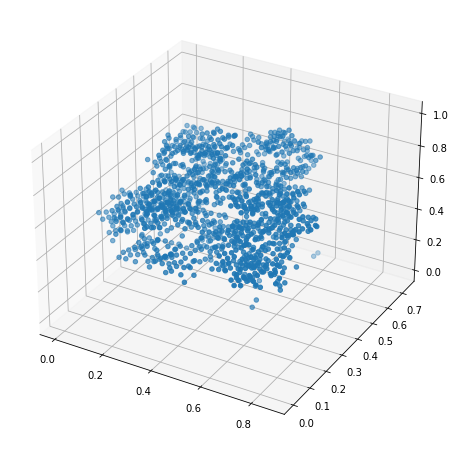

0it [00:00, ?it/s]


In [21]:
#scale 0:1
normalized_trees = {}
print("normalizing clusters")
for i, row in tqdm(intersections2.iterrows()):
    points = numpy.array(cluster_dict[row.HULL_DICT_KEY])
    
    print(x)
    points = points/ numpy.max(points)   
    normalized_trees[row.HULL_DICT_KEY] = points
    print(points)
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    z = [point[2] for point in points]

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z)
    plt.show()
    break


In [14]:
counter = 0
c_id = [] 
t_id = []
g_id = [] 
a_id = []
xs = []
ys = []
zs = []
print("saving")
req  = """INSERT INTO LIDAR_PROJ.CLUSTER (ID, TREE_ID, ID_GATTUNG, PATH_ID, ALGO_ID) VALUES"""
for k in tqdm(normalized_trees.keys()):
    counter +=1
    max_id += 1        
    normalized_points = normalized_trees[k]     
    row_df = intersections2.loc[intersections2['HULL_DICT_KEY'] == k]
    try:
        row = row_df.iloc[0]
    except:
        row= row_df  
        print("except:", row)

    tree_id =row['ID']
    gattung_id =row['ID_GATTUNG']

    req = req + str(save(max_id, tree_id, gattung_id, save_path_id, algo_id))       

    save_path = os.path.join(save_to,str(max_id) + ".las")
    #c_las.write(save_path)
    for n_point in numpy.array(normalized_points):
        c_id.append(max_id)
        t_id.append(tree_id)
        g_id.append(gattung_id)
        a_id.append(algo_id)
        xs.append(n_point[0])
        ys.append(n_point[1])
        zs.append(n_point[2])
    


     
    if counter % 100 == 0:
        req= req[:-1]
        print(req)
        db.execute(req)
        
        print("commit")
        db.commit()
        req  = """INSERT INTO LIDAR_PROJ.CLUSTER (ID, TREE_ID, ID_GATTUNG, PATH_ID, ALGO_ID) VALUES """

req= req[:-1]
db.execute(req)
db.commit()
csv_frame = pandas.DataFrame({"Cluster_ID":c_id, "Tree_ID": t_id, "GATTUNGS_ID": g_id, "ALGO_ID": a_id, "x": xs, "y": ys, "z": zs})

print("save to ", csv_save_path)

csv_frame.to_csv(csv_save_path,mode='a+')

print("finish!")
print("time needed: ", datetime.now() - start_time)

saving


 69%|██████▉   | 70/101 [00:00<00:00, 317.98it/s]

INSERT INTO LIDAR_PROJ.CLUSTER (ID, TREE_ID, ID_GATTUNG, PATH_ID, ALGO_ID) VALUES (603, 102329, 10, 100, 1), (604, 102330, 10, 100, 1), (605, 102344, 115, 100, 1), (606, 102347, 90, 100, 1), (607, 102353, 116, 100, 1), (608, 102384, 69, 100, 1), (609, 102388, 116, 100, 1), (610, 102397, 81, 100, 1), (611, 102483, 116, 100, 1), (612, 102540, 3, 100, 1), (613, 102582, 3, 100, 1), (614, 102619, 116, 100, 1), (615, 102636, 116, 100, 1), (616, 102637, 116, 100, 1), (617, 102644, 70, 100, 1), (618, 102696, 116, 100, 1), (619, 102697, 116, 100, 1), (620, 102834, 71, 100, 1), (621, 102842, 103, 100, 1), (622, 102846, 71, 100, 1), (623, 102847, 71, 100, 1), (624, 102855, 4, 100, 1), (625, 102856, 33, 100, 1), (626, 102858, 16, 100, 1), (627, 102869, 94, 100, 1), (628, 102870, 69, 100, 1), (629, 102872, 116, 100, 1), (630, 102879, 103, 100, 1), (631, 102928, 116, 100, 1), (632, 102938, 69, 100, 1), (633, 102940, 81, 100, 1), (634, 102946, 32, 100, 1), (635, 102949, 2, 100, 1), (636, 102975, 116,

100%|██████████| 101/101 [00:00<00:00, 106.03it/s]


save to  C:\Users\janja\Desktop\GitHub\lidar-vegetation-data\clusters\test/3dm_32_326_5728_1_nw_clusters.csv
finish!
time needed:  0:15:38.957593
